# Problem 2

My two algorithms use a lot of numpy arrays so to refresh the memeory about arrays in python, please read

https://docs.scipy.org/doc/numpy-dev/user/quickstart.html

Remember:
shape = (rows, columns)

## 1. Loading the dataset - Boston -

For this problem we are going to use the Boston dataset. Due to the deadline to hand this project my I do not perform a thourogh data analysis but I rather focus on the algorithms.

In [1]:
# load libraries
import numpy as np
import pandas as pd

In [2]:
dat = pd.read_csv('Boston.csv').dropna()
dat.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
# Extracting the data and the target.
X = np.array(dat.iloc[:,:-1].values)
#X = np.array(dat.iloc[:,[5,12]].values)
y = np.array(dat.iloc[:,13].values).reshape(-1,1)

In [4]:
print('X dim:', X.shape)
print('y dim:', y.shape)

X dim: (506, 13)
y dim: (506, 1)


In [5]:
#np.asscalar(np.dot(X.T,y))

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Dividing the data set in 50% of train and 50% of test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=0)

In [8]:
# normalizing the dataset is always good practice
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

In [9]:
X_train_sc=sc_x.fit_transform(X_train)
y_train_sc=sc_y.fit_transform(y_train.reshape(-1,1))

X_test_sc = sc_x.transform(X_test)
y_test_sc = sc_y.transform(y_test.reshape(-1,1))

### 1.1. Exploratory Data Analysis

Here I just want to visualize the data. Just to know what to expect from a blind regression.

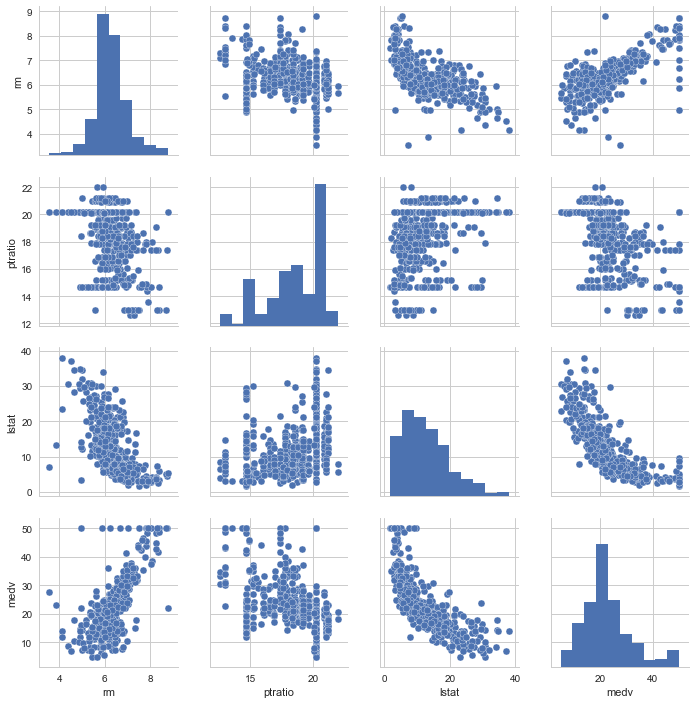

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='notebook')
cols = [ 'rm', 'age', 'dis', 'tax','ptratio','lstat','black','medv']
cols = [ 'rm','ptratio','lstat','medv']
sns.pairplot(dat[cols], size=2.5)
plt.show()

### 1.2. Constructing the weight matrix

This caused some problems so I decided to set the weight matrix to the identity. Actually after a few mods to the algorithms I chose, this part is not necessary anymore.

In [11]:
from sklearn.linear_model import LinearRegression
slr=LinearRegression()
slr.fit(X_train_sc, y_train_sc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
res = slr.predict(X_train_sc) - y_train_sc

In [13]:
# creating the weight matrix and normalizing it
W = np.diagflat(1/res**2)
Wmax=np.amax(W)

In [14]:
W = W/ Wmax

In [15]:
# I want to use the identity for now.
W =np.identity(X_train_sc.shape[0])

In [16]:
# Checking the coefficient of the regression
slr.coef_

array([[-0.1160751 ,  0.1438898 ,  0.05387264,  0.08823602, -0.19912322,
         0.27192659, -0.00881289, -0.32867001,  0.22535303, -0.17490753,
        -0.2542458 ,  0.05282481, -0.4393473 ]])

In [17]:
slr.intercept_

array([  3.03766202e-15])

## 2. The optimization algorithms

Since we need to perform a grid search later (for the parallelized CV) I follow this very useful article

http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/

to create my 2 regressors with the sklearn interface

### 2.1. Sub-gradient Descent

In [18]:
# Implementing the sub-gradient descent algorithm according to the sklearn interface.
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression # not used now
from sklearn.metrics import r2_score
import numpy as np
import time

class WEN_sGD(BaseEstimator, RegressorMixin):
    
    def __init__(self, lambda_1=0.01, lambda_2=0.01, eta=0.0001, n_iter=150, feedback=False):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.eta      = eta 
        self.n_iter   = n_iter
        self.feedback = feedback
        
    def fit(self, X, y=None):
        
        # Generate the weight matrix
        W = self.generate_weights(X,y)
        
        # Initializing the betas
        self.beta_ = np.zeros(1+X.shape[1]).reshape(-1,1)
        self.cost_ = []
        
        time0 = time.clock()
        
        # Defining the X0 vector
        X0 = np.ones(X.shape[0]).reshape(-1,1)

        #print('X0:', X0)
            
        # Defining a few useful terms
        ID     = np.identity(X.shape[1])
        Xt     = np.transpose(X)
        yt     = np.transpose(y)
        
        WX     = W    @ X
        XtW    = X.T  @ W
        XtWX   = XtW  @ X
        WX0    = W    @ X0
        X0tW   = X0.T @ W
        XtWX0  = XtW  @ X0
        X0tWX  = X0tW @ X
        X0tWX0 = np.asscalar(X0.T @ WX0)
        ytWX0  = np.asscalar(y.T  @ WX0)
        ytW    = y.T  @ W
        
        if(self.feedback):
            print('Time to compute the linalg elements:', time.clock() - time0) 
            print('')
            print('--- Optimization: ---')
        
        time1 = time.clock()
        
        for i_iter in range(self.n_iter):
            
            # Defining quantities depending on beta
            b     = self.beta_[1:]
            b0    = self.beta_[0]
            bt    = b.T            
            Xb    = X   @ b
            WXb   = W   @ Xb
            ytWXb = np.asscalar(y.T @ WXb)
            
            obj = (np.asscalar(bt @ (XtWX @ b)) + self.lambda_2*np.asscalar(bt @ b) + 2*b0 * np.asscalar(bt @ XtWX0)
                   + b0**2 * (X0tWX0 + self.lambda_2))
            
            obj = obj/(1.+self.lambda_2)
            
            obj = obj - 2*ytWXb - 2*b0*ytWX0
            
            # computing the lasso penalization
            lasso = 0
            # Apparently we do not regularize the intercept.
            for i in range(1,1+X.shape[1]):
                lasso += abs(self.beta_[i])
                
            lasso = lasso*self.lambda_1
            
            # adding the rest
            obj += lasso
            
            # store the cost function
            if (self.feedback):
                print('iter:', i_iter, 'obj:', obj)
                
            self.cost_.append(obj)
            
            # Now update the regressioin coefficients
            # L =/ 0
            for L in range(X.shape[1]):

                # doing some operations
                XL     = X[:,L].reshape(-1,1)
                XLt    = XL.T
                XLtWXb = np.asscalar(XL.T @ WXb)
                XLtWX0 = np.asscalar(XL.T @ WX0)
                ytWXL  = np.asscalar(ytW @ XL)
                
                # useful outputs
                #print('XL     shape:', XL.shape)
                #print('XLt    shape:', XLt.shape)
                #print('XLtWXb shape:', XLtWXb.shape)
                #print('ytWX0  shape:', ytWX0.shape)
                #print('ytWXL  shape:', ytWXL.shape)
                
                grad = 2*((XLtWXb+self.lambda_2*self.beta_[L+1] + XLtWX0*b0)/(1+self.lambda_2)- ytWXL)
                
                # subgradient part
                if (self.beta_[1+L] >  0):
                    grad = grad+self.lambda_1
                elif(self.beta_[1+L] < 0):
                    grad = grad - self.lambda_1
                
                self.beta_[1+L] += self.eta*(-grad)
                
            # Updating the intercept
            grad0 = 2*((np.asscalar(X0tWX @ b) + X0tWX0 *b0+self.lambda_2*b0)/(1+self.lambda_2)- ytWX0)
            
            if (self.beta_[0]>0):
                grad0+=self.lambda_1
            elif(self.beta_[0]<0):
                grad0+=(-self.lambda_1)
            
            self.beta_[0]+=grad0*(-self.eta)
            
        if(self.feedback): 
            print('Time for optimization:', time.clock()-time1)
        
        return self

    def predict(self, X):
        try:
            getattr(self, "beta_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return np.dot(X, self.beta_[1:])+self.beta_[0]     
    
    def score(self, X, y=None):
        return r2_score(y,self.predict(X))
    
    def generate_weights(self,X,y=None):
        # Here I could put a OLS to generate the weights
        # but now I prefer to work with the identity 
        return np.identity(X.shape[0])
        
            

### 2.2. Proximal Gradient Descent

We can easily modify the sub-gradient descent to obtain the proximal gradient descent.

In [19]:
# Implementing the sub-gradient descent algorithm according to the sklearn interface.
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression # not used now
from sklearn.metrics import r2_score
import numpy as np
import time

class WEN_pGD(BaseEstimator,RegressorMixin):
    
    def __init__(self, lambda_1=0.1, lambda_2=0.001, eta=0.0001, n_iter=150, feedback=False):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.eta      = eta 
        self.n_iter   = n_iter
        self.feedback = feedback
        
    def fit(self, X, y=None):
        # Generating the weights
        W = self.generate_weights(X,y)
        
        # Initializing th eregression coefficients
        self.beta_ = np.zeros(1+X.shape[1]).reshape(-1,1)
        
        # Initializing the cost/epoch list
        self.cost_ = []
        
        time0 = time.clock()
        
        # Defining the X0 vector
        X0 = np.ones(X.shape[0]).reshape(-1,1)
            
        # Defining a few useful terms (once only so the thing should run faster)
        ID     = np.identity(X.shape[1])
        Xt     = np.transpose(X)
        yt     = np.transpose(y)
        WX     = W    @ X
        XtW    = X.T  @ W
        XtWX   = XtW  @ X
        WX0    = W    @ X0
        X0tW   = X0.T @ W
        XtWX0  = XtW  @ X0
        X0tWX  = X0tW @ X
        X0tWX0 = np.asscalar(X0.T @ WX0)
        ytWX0  = np.asscalar(y.T  @ WX0)
        ytW    = y.T  @ W
        
        if(self.feedback):
            print('Time to compute the linalg elements:', time.clock() - time0)
            print('')
            print('--- Optimization: ---')
            
        time1 = time.clock()
        
        for i_iter in range(self.n_iter):
            
            # Defining quantities depending on beta
            b     = self.beta_[1:]
            b0    = self.beta_[0]
            bt    = b.T            
            Xb    = X   @ b
            WXb   = W   @ Xb
            ytWXb = np.asscalar(y.T @ WXb)
            
            obj = (np.asscalar(bt @ (XtWX @ b)) + self.lambda_2*np.asscalar(bt @ b) + 2*b0 * np.asscalar(bt @ XtWX0)
                   + b0**2 * (X0tWX0 + self.lambda_2))
            
            obj = obj/(1.+self.lambda_2)
            
            obj = obj - 2*ytWXb - 2*b0*ytWX0
            
            # computing the lasso penalization
            lasso = 0
            
            # Apparently we do not regularize the intercept.
            for i in range(1,1+X.shape[1]):
                lasso += abs(self.beta_[i])
                
            lasso = lasso*self.lambda_1
            
            # adding the rest
            obj += lasso
            
            # store the cost function
            self.cost_.append(obj)
            
            # print the cost function
            if(self.feedback):
                print('iter:', i_iter, 'obj:', obj)
            
            # Now update the regressioin coefficients using the proximal GD
            # L =/ 0
            
            for L in range(X.shape[1]):

                # doing some operations
                XL     = X[:,L].reshape(-1,1)
                XLt    = XL.T
                XLtWXb = np.asscalar(XL.T @ WXb)
                XLtWX0 = np.asscalar(XL.T @ WX0)
                ytWXL  = np.asscalar(ytW @ XL)
                
                grad = 2*((XLtWXb+self.lambda_2*self.beta_[L+1] + XLtWX0*b0)/(1+self.lambda_2)- ytWXL)
                
                # arguments of the soft threshold function
                x   = self.beta_[1+L] - self.eta * grad
                lam = self.eta*self.lambda_1
                
                self.beta_[1+L] = self.soft_threshold(x, lam)
                
            # Updating the intercept
            grad0 = 2*((np.asscalar(X0tWX @ b) + X0tWX0 *b0+self.lambda_2*b0)/(1+self.lambda_2)- ytWX0)
            
            x   = self.beta_[0] - self.eta*grad0
            lam = self.eta*self.lambda_1
            
            self.beta_[0] = self.soft_threshold(x,lam)
            
            
        #print('Time for optimization:', time.clock()-time1)
        
        return self

    def predict(self, X):
        try:
            getattr(self, "beta_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return np.dot(X, self.beta_[1:])+self.beta_[0]  
            
    def soft_threshold(self, x, lam):
        if (x > lam):
            return x-lam
        elif(x < -lam):
            return x+lam
        else:
            return 0
    
    
    def score(self, X, y=None):
        return r2_score(y,self.predict(X))
    
    def generate_weights(self,X,y=None):
        # Here I could put an OLS to generate the weights
        # but now I prefer to work with the identity 
        return np.identity(X.shape[0])
        

## 3. Testing the algorithms

### 3.1. OLS limit of the two algorithms
Below I try the two algorithms above using $\lambda_1 = \lambda_2 = 0$. This is exaclty the same as the OLS and the two algorithms should be the same in this case.

In [20]:
wen1 = WEN_sGD(lambda_1=0,lambda_2=0,eta=0.0001,n_iter=200,feedback=False)
wen2 = WEN_pGD(lambda_1=0,lambda_2=0,eta=0.0001,n_iter=200,feedback=False)

In [21]:
wen1.fit(X_train_sc, y_train_sc)

WEN_sGD(eta=0.0001, feedback=False, lambda_1=0, lambda_2=0, n_iter=200)

In [22]:
wen2.fit(X_train_sc, y_train_sc)

WEN_pGD(eta=0.0001, feedback=False, lambda_1=0, lambda_2=0, n_iter=200)

In [23]:
print('beta1:',wen1.beta_)
print('beta2:',wen2.beta_)

beta1: [[  2.97180600e-15]
 [ -1.10445498e-01]
 [  1.20662849e-01]
 [  2.12788821e-03]
 [  9.69195524e-02]
 [ -1.40674761e-01]
 [  2.99595671e-01]
 [ -2.40304100e-02]
 [ -2.91557346e-01]
 [  1.24675751e-01]
 [ -6.75159337e-02]
 [ -2.42036442e-01]
 [  5.52335834e-02]
 [ -4.22336141e-01]]
beta2: [[  2.97180600e-15]
 [ -1.10445498e-01]
 [  1.20662849e-01]
 [  2.12788821e-03]
 [  9.69195524e-02]
 [ -1.40674761e-01]
 [  2.99595671e-01]
 [ -2.40304100e-02]
 [ -2.91557346e-01]
 [  1.24675751e-01]
 [ -6.75159337e-02]
 [ -2.42036442e-01]
 [  5.52335834e-02]
 [ -4.22336141e-01]]


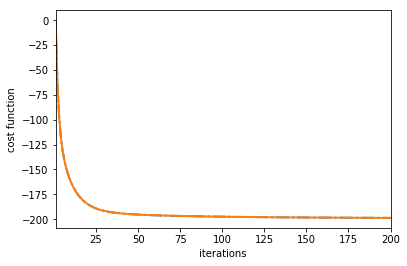

In [24]:
sns.reset_orig()
plt.plot(range(1, wen1.n_iter+1), wen1.cost_, linewidth =2, linestyle= '-.')
plt.plot(range(1, wen2.n_iter+1), wen2.cost_, linewidth =2, linestyle = '-')
plt.xlim(1,200)
plt.ylabel('cost function')
plt.xlabel('iterations')
plt.show()

### 3.2. Lasso Limit

Here we set only $\lambda_2 = 0$ and compare the result with the Lasso model from sklearn

#### 3.1. Choosing the best $\lambda_1$

In [25]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in range(len(param_range)):
    lasso = Lasso(alpha=param_range[i], random_state=1)
    lasso.fit(X_train_sc,y_train_sc)
    r2=r2_score(y_test_sc, lasso.predict(X_test_sc))
    print('lambda:', lasso.alpha, 'r2:', r2)
    

lambda: 0.0001 r2: 0.666291334493
lambda: 0.001 r2: 0.666377542875
lambda: 0.01 r2: 0.659947175286
lambda: 0.1 r2: 0.622993714681
lambda: 1 r2: -0.0140588213417
lambda: 10 r2: -0.0140588213417
lambda: 100 r2: -0.0140588213417
lambda: 1000 r2: -0.0140588213417


In [26]:
lasso = Lasso(alpha=0.01, random_state = 1)
lasso.fit(X_train_sc, y_train_sc)
print('intercept:', lasso.intercept_)
print('coeff    :', lasso.coef_)

intercept: [  2.95589992e-15]
coeff    : [-0.08973424  0.11036125 -0.          0.08959662 -0.1403563   0.28552206
 -0.         -0.26630032  0.07817229 -0.03537397 -0.23918791  0.04199728
 -0.43952393]


In [27]:
# now trying the wen in this limit.
wen1 = WEN_sGD(lambda_1=0.01,lambda_2=0,eta=0.0001,n_iter=200)
wen2 = WEN_pGD(lambda_1=0.01,lambda_2=0,eta=0.0001,n_iter=200)

In [28]:
wen1.fit(X_train_sc, y_train_sc)

WEN_sGD(eta=0.0001, feedback=False, lambda_1=0.01, lambda_2=0, n_iter=200)

In [29]:
wen2.fit(X_train_sc, y_train_sc)

WEN_pGD(eta=0.0001, feedback=False, lambda_1=0.01, lambda_2=0, n_iter=200)

In [30]:
print('beta1:',wen1.beta_)
print('beta2:',wen2.beta_)

beta1: [[ -5.12995041e-07]
 [ -1.10401119e-01]
 [  1.20622272e-01]
 [  2.11502151e-03]
 [  9.69093694e-02]
 [ -1.40612735e-01]
 [  2.99606373e-01]
 [ -2.39886675e-02]
 [ -2.91444207e-01]
 [  1.24537158e-01]
 [ -6.74236012e-02]
 [ -2.42019998e-01]
 [  5.52133408e-02]
 [ -4.22345800e-01]]
beta2: [[ 0.        ]
 [-0.11040101]
 [ 0.12062204]
 [ 0.00211348]
 [ 0.09690944]
 [-0.14061232]
 [ 0.29960632]
 [-0.02398846]
 [-0.29144422]
 [ 0.12453685]
 [-0.06742289]
 [-0.24201986]
 [ 0.05521327]
 [-0.42234568]]


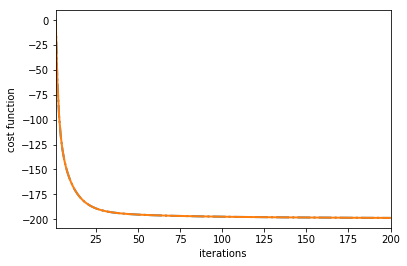

In [31]:
sns.reset_orig()
plt.plot(range(1, wen1.n_iter+1), wen1.cost_, linewidth =2, linestyle= '-.')
plt.plot(range(1, wen2.n_iter+1), wen2.cost_, linewidth =2, linestyle = '-')
plt.xlim(1,200)
plt.ylabel('cost function')
plt.xlabel('iterations')
plt.show()

### 3.3. Elastic Net

In [32]:
from sklearn.linear_model import ElasticNet
EN = ElasticNet(alpha=0.01, l1_ratio = 0.5)

In [33]:
EN.fit(X_train_sc,y_train_sc)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
EN.coef_

array([-0.10253187,  0.123007  ,  0.        ,  0.09082842, -0.15883193,
        0.2798557 , -0.001579  , -0.2934616 ,  0.13323569, -0.08036839,
       -0.2426794 ,  0.047238  , -0.43449478])

In [35]:
EN.intercept_

array([  3.00867581e-15])

In [36]:
wen1 = WEN_sGD(lambda_1=1.0,lambda_2=0.001,eta=0.0001,n_iter=200)
wen2 = WEN_pGD(lambda_1=1.0,lambda_2=0.0001,eta=0.0001,n_iter=200)

In [37]:
wen2.lambda_2

0.0001

In [38]:
wen1.fit(X_train_sc, y_train_sc)

WEN_sGD(eta=0.0001, feedback=False, lambda_1=1.0, lambda_2=0.001, n_iter=200)

In [39]:
wen2.fit(X_train_sc, y_train_sc)

WEN_pGD(eta=0.0001, feedback=False, lambda_1=1.0, lambda_2=0.0001, n_iter=200)

In [40]:
print('beta1:',wen1.beta_)
print('beta2:',wen2.beta_)

beta1: [[ -5.12981971e-05]
 [ -1.06105367e-01]
 [  1.16627051e-01]
 [  1.50563813e-04]
 [  9.60278856e-02]
 [ -1.34407646e-01]
 [  3.00951749e-01]
 [ -1.98162330e-02]
 [ -2.80565174e-01]
 [  1.10916069e-01]
 [ -5.81448607e-02]
 [ -2.40561291e-01]
 [  5.32454995e-02]
 [ -4.23622308e-01]]
beta2: [[  0.00000000e+00]
 [ -1.06000926e-01]
 [  1.16522679e-01]
 [  1.13856510e-05]
 [  9.59424741e-02]
 [ -1.34310910e-01]
 [  3.00638673e-01]
 [ -1.97652844e-02]
 [ -2.80374289e-01]
 [  1.10841471e-01]
 [ -5.80681758e-02]
 [ -2.40342777e-01]
 [  5.31849514e-02]
 [ -4.23257174e-01]]


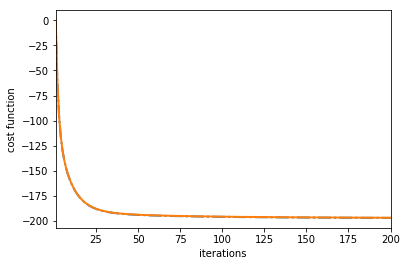

In [41]:
sns.reset_orig()
plt.plot(range(1, wen1.n_iter+1), wen1.cost_, linewidth =2, linestyle= '-.')
plt.plot(range(1, wen2.n_iter+1), wen2.cost_, linewidth =2, linestyle = '-')
plt.xlim(1,200)
plt.ylabel('cost function')
plt.xlabel('iterations')
plt.show()

In [42]:
# Choosing the regularization parameters - A very inefficient Grid Search approach -
from sklearn.metrics import r2_score

param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
print('--- SUB-GRADIENT ---')
print('lam1, lam2, r2')
for i in range(len(param_range)):
    for j in range(len(param_range)):
        lambda_1 = param_range[i]
        lambda_2 = param_range[j]
        wen1 = WEN_sGD(lambda_1=lambda_1,lambda_2=lambda_2,eta=0.0001,n_iter=200)
        wen1.fit(X_train_sc, y_train_sc)
        nz = np.count_nonzero(wen1.beta_)
        r2=r2_score(y_test_sc,wen1.predict(X_test_sc))
        print(lambda_1, lambda_2, r2, nz)
print('')
print('--- PROXIMAL GRADIENT ---')
print('lam1, lam2, r2')
for i in range(len(param_range)):
    for j in range(len(param_range)):
        lambda_1 = param_range[i]
        lambda_2 = param_range[j]
        wen2 = WEN_pGD(lambda_1=lambda_1,lambda_2=lambda_2,eta=0.0001,n_iter=200)
        wen2.fit(X_train_sc, y_train_sc)
        nz = np.count_nonzero(wen2.beta_)
        r2=r2_score(y_test_sc,wen2.predict(X_test_sc))
        print(lambda_1, lambda_2, r2,nz)
        


--- SUB-GRADIENT ---
lam1, lam2, r2
0.0001 0.0001 0.661391743475 14
0.0001 0.001 0.66123428952 14
0.0001 0.01 0.659583729342 14
0.0001 0.1 0.635475515866 14
0.0001 1 -0.361342753114 14
0.0001 10 -62.7305612848 14
0.0001 100 -965.943428749 14
0.0001 1000 -1594.98070047 14
0.001 0.0001 0.661391301827 14
0.001 0.001 0.661233851282 14
0.001 0.01 0.659583317534 14
0.001 0.1 0.63547542407 14
0.001 1 -0.361333348989 14
0.001 10 -62.7300851684 14
0.001 100 -965.935519309 14
0.001 1000 -1594.96772137 14
0.01 0.0001 0.661386997913 14
0.01 0.001 0.661229461071 14
0.01 0.01 0.659579191563 14
0.01 0.1 0.635474497291 14
0.01 1 -0.361239324583 14
0.01 10 -62.7253241318 14
0.01 100 -965.85642674 14
0.01 1000 -1594.83793334 14
0.1 0.0001 0.661343055737 14
0.1 0.001 0.661185981705 14
0.1 0.01 0.659537142505 14
0.1 0.1 0.63546434774 14
0.1 1 -0.360300765688 14
0.1 10 -62.6777265442 14
0.1 100 -965.065684318 14
0.1 1000 -1593.54034905 14
1 0.0001 0.660890066063 14
1 0.001 0.660723842587 14
1 0.01 0.659103

In [43]:
wen1 = WEN_sGD(lambda_1=10,lambda_2=0.0001,eta=0.0001,n_iter=200)
t0 = time.time()
wen1.fit(X_train_sc, y_train_sc)
t1 = time.time()
wen2 = WEN_pGD(lambda_1=10,lambda_2=0.0001,eta=0.0001,n_iter=200)
t2 = time.time()
wen2.fit(X_train_sc,y_train_sc)
t3 = time.time()

In [44]:
print('Sub-Gradient  time:', t1-t0)
print('Prox-Gradient time:', t3-t2)

Sub-Gradient  time: 0.10317492485046387
Prox-Gradient time: 0.07031607627868652


In [45]:
print('beta_1:',wen1.beta_)
print('beta_2:',wen2.beta_)

beta_1: [[ -5.12993735e-04]
 [ -6.68617814e-02]
 [  7.98692528e-02]
 [  2.75483953e-04]
 [  8.64993701e-02]
 [ -6.91105832e-02]
 [  3.11271200e-01]
 [ -7.75680659e-04]
 [ -1.85395826e-01]
 [  6.83843183e-05]
 [ -1.40775340e-03]
 [ -2.22422478e-01]
 [  3.48662655e-02]
 [ -4.27610340e-01]]
beta_2: [[ 0.        ]
 [-0.06674397]
 [ 0.07988163]
 [ 0.        ]
 [ 0.08650359]
 [-0.0693732 ]
 [ 0.31132372]
 [ 0.        ]
 [-0.18484299]
 [ 0.        ]
 [ 0.        ]
 [-0.22254783]
 [ 0.03487354]
 [-0.42790488]]


The coefficients look similar to the EN from sklearn and are similar. The proximal GD looks faster although the measurement of time I used include the other things that the computer is doing. However I think I'm choosing the proximal gradient descent method. We have more sparsity of the parameters $\to$ simpler model.

## 4. Model Validation & Parallelization

### 4.1. Cross Validation

We now perform a parallelized cross validation to infer the best parameters $\lambda_1$ and $\lambda_2$

In [100]:
# trying with this. I have to define the pipeline, otherwise I'm always using the scaled set.
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

param_range1 = [10**(-2+0.04*(i+1)) for i in range(100)]
param_range2 = [10**(-3+0.05*(i+1)) for i in range(100)]

pipe_wen = Pipeline([('scl', StandardScaler()),
                    ('clf', WEN_pGD())])

param_grid = [{'clf__lambda_1':param_range1, 'clf__lambda_2':param_range2}]
gs = GridSearchCV(estimator=pipe_wen, param_grid=param_grid, scoring = 'neg_mean_absolute_error', cv=10, n_jobs=-1)

In [101]:
t0 =time.time()
gs.fit(X_train,y_train)
t1=time.time()

In [102]:
print('time for the CV grid search:', t1-t0, 'seconds')

time for the CV grid search: 2875.921070098877 seconds


In [103]:
gs.best_params_

{'clf__lambda_1': 30.19951720402016, 'clf__lambda_2': 0.001122018454301963}

In [104]:
gs.best_score_

-3.2684609793730073

In [105]:
gs.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', WEN_pGD(eta=0.0001, feedback=False, lambda_1=30.19951720402016,
    lambda_2=0.001122018454301963, n_iter=150))])>

### 4.2. Bootstrapping (or BAGGING?)

Here I implement a (hopefully parallelized) bagging regressor based on the proximal-GD WEN defined above.

I read the following

https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/

but it was not that helpful.


In [65]:
from sklearn.ensemble import BaggingRegressor

In [67]:
bagg = BaggingRegressor(base_estimator=WEN_pGD(),n_estimators=10,bootstrap=True, max_samples=0.5, max_features=0.5, n_jobs=-1)

In [69]:
bagg.get_params

<bound method BaseEstimator.get_params of BaggingRegressor(base_estimator=WEN_pGD(eta=0.0001, feedback=False, lambda_1=0.1, lambda_2=0.001, n_iter=150),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)>

In [72]:
bagg.fit(X_train_sc,np.ravel(y_train_sc))

BaggingRegressor(base_estimator=WEN_pGD(eta=0.0001, feedback=False, lambda_1=0.1, lambda_2=0.001, n_iter=150),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [79]:
bagg.estimators_[4].beta_

array([[ 0.06359128],
       [ 0.1006974 ],
       [-0.13850028],
       [-0.17098411],
       [-0.5586329 ],
       [ 0.05810117],
       [ 0.12965539]])

I don't quite understand how to obtain the confidence level over $\lambda_1$ and $\lambda_2$. I need more time to think.

## 5. Variable Selection

### 5.1. Coefficient paths

In [43]:
log_param_1_range=[-3+0.06*(i+1) for i in range(100)]

In [44]:
beta_step = np.zeros((100,X_train.shape[1]+1))

In [45]:
for i in range(len(log_param_1_range)):
    loglam1 = log_param_1_range[i]
    lam1    = 10**log_param_1_range[i]
    wen     = WEN_pGD(lambda_1=lam1, lambda_2=0.00112, eta=0.0001,n_iter=200,feedback=False)
    
    wen.fit(X_train_sc,y_train_sc)
    
    beta_step[i,0] = loglam1
    
    # filling the array
    for j in range(X_train_sc.shape[1]):
        beta_step[i,1+j]= wen.beta_[1+j]

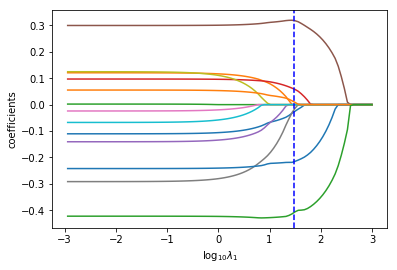

In [46]:
from itertools import cycle
import pylab as pil
#colors = cycle(['b', 'r', 'g', 'c', 'k'])
for i_var in range(X_train_sc.shape[1]):
    plt.plot(beta_step[:,0], beta_step[:,i_var+1])
    
plt.xlabel(r'$\log_{10} \lambda_1$')
plt.ylabel('coefficients')
plt.axvline(x=1.48, color='b', linestyle='--')
pil.savefig('coeff_paths.pdf', bbox_inches='tight')
plt.show()

In [47]:
optimal_wen=WEN_pGD(lambda_1=30.1995,lambda_2=0.00112)

In [48]:
optimal_wen.fit(X_train_sc,y_train_sc)

WEN_pGD(eta=0.0001, feedback=False, lambda_1=30.1995, lambda_2=0.00112,
    n_iter=150)

In [50]:
not0coeff = np.count_nonzero(optimal_wen.beta_[1:])

In [52]:
print('The WEN selected', not0coeff, 'variables.')

The WEN selected 7 variables.


In [54]:
optimal_coeff=optimal_wen.beta_[1:]
print('optimal coefficients: \n', optimal_coeff)

optimal coefficients: 
 [[-0.02995666]
 [ 0.        ]
 [ 0.        ]
 [ 0.05909977]
 [ 0.        ]
 [ 0.32382294]
 [ 0.        ]
 [-0.01728384]
 [ 0.        ]
 [ 0.        ]
 [-0.2152775 ]
 [ 0.01165082]
 [-0.40150232]]


### 5.3. increasing $\lambda_2$

In [62]:
for i in range(len(log_param_1_range)):
    loglam1 = log_param_1_range[i]
    lam1    = 10**log_param_1_range[i]
    wen     = WEN_pGD(lambda_1=lam1, lambda_2=1.0, eta=0.0001,n_iter=200,feedback=False)
    
    wen.fit(X_train_sc,y_train_sc)
    
    beta_step[i,0] = loglam1
    
    # filling the array
    for j in range(X_train_sc.shape[1]):
        beta_step[i,1+j]= wen.beta_[1+j]

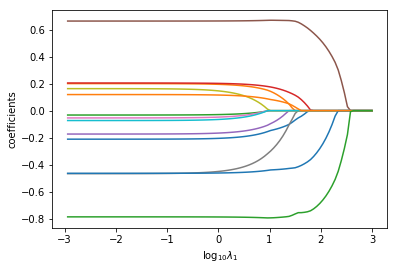

In [63]:
from itertools import cycle
import pylab as pil
#colors = cycle(['b', 'r', 'g', 'c', 'k'])
for i_var in range(X_train_sc.shape[1]):
    plt.plot(beta_step[:,0], beta_step[:,i_var+1])
    
plt.xlabel(r'$\log_{10} \lambda_1$')
plt.ylabel('coefficients')
#plt.axvline(x=1.48, color='b', linestyle='--')
pil.savefig('coeff_paths2.pdf', bbox_inches='tight')
plt.show()